# RelativisticDynamics.jl demo

This notebook demonstrates how to use the `RelativisticDynamics.jl` package

In [19]:
using Revise
using RelativisticDynamics

## Orbital Trajectory

The core aim of `RelativisticDynamics.jl` is to be able to accuratley describe the spin-orbital evolution of a relativistic system. This can be easily done using the default settings as:

In [20]:
solution,model = orbit();

RelativisticDynamics.SystemParameters
  NF: Float64 <: AbstractFloat
  a: Float64 0.1
  mBH: Float64 4.0e6
  mPSR: Float64 1.4
  rPSR: Float64 10.0
  p0: Float64 0.001
  Sθ: Float64 0.5235987755982988
  Sϕ: Float64 0.0
  α: Float64 50.0
  e: Float64 0.5
  ι: Float64 0.5235987755982988
  orbit_dir: Int64 1
  Norbits: Float64 10.0


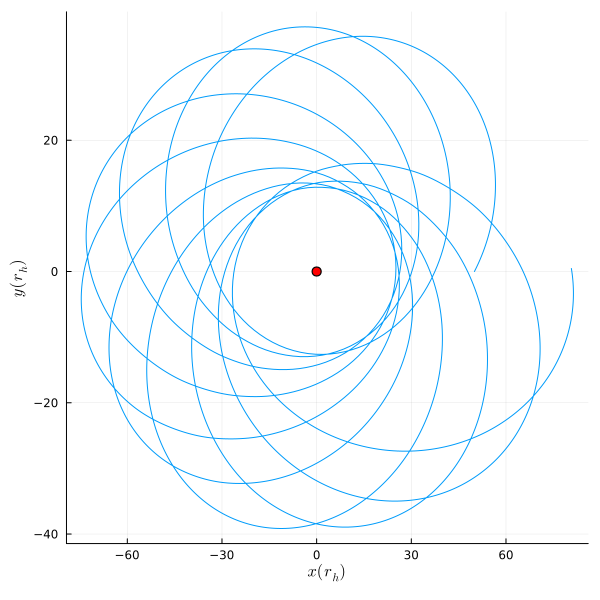

Plotting the solution generated with the following user defined parameters
-------------------------------


In [21]:
PlotTrajectory(solution,model,[1,2])

## Flexible number format

## Differentiation using Zygote.jl

`RelativisticDynamics.jl` is written so as to be generally differentiable by the [differentiation tools in Julia](https://juliadiff.org/).

Specifically, we have been working using [Zygote.jl](https://fluxml.ai/Zygote.jl/latest/).

Let's see how this works by trying to see how the orbit varies with eccentricity, i.e. we want to calculate

$$\frac{\partial L}{\partial e} $$

where $L$ is some loss function that depends on the output of `orbit()`, which we will define below.


First we need to define a reference solution against which gradients can be calculated:


In [22]:
# Get a reference solution.
# We will use this to define a gradient 
reference_solution,reference_model = orbit(Norbits=1); #using the default parameters

...and then a loss function. Here we are just using some arbitrary loss that compares the difference in the final value of the $r$-coordinate at the end of the integration.

In [23]:
function loss_function(reference,e)

    # Run the model using the new value of e
    solution,model = orbit(e=e,Norbits=1)
    

    r0 = last(reference[2,:])  # The last r value of the reference solution
    r = last(solution[2,:])    # The last r value of the new solution
    loss = abs(r0 - r)         # Loss
  
    return loss

end

loss_function (generic function with 1 method)

We can explore explicitly how this loss function varies with $e$:

In [24]:
N = 20 #number of samples
loss_data = zeros(Float64,N,2)
for (i,v) in pairs(range(0.1,0.9,N))

    loss = loss_function(reference_solution,v)
    loss_data[i,1] = v 
    loss_data[i,2] = loss

end

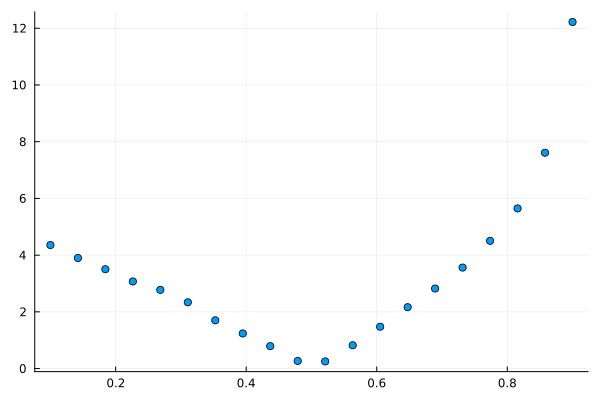

In [25]:
using Plots 
scatter(loss_data[:,1], loss_data[:,2],legend=false) # eccentricity vs loss 

Ok that makes sense - the loss is minimal at $e=0.5$ which is the value used in the reference solution and then diverges at low/high $e$.

Now, can we also get the gradient of this curve using `Zygote.jl`?

Yes! We just need to change one line from above:

In [26]:
using Zygote 

loss_gradient_data = zeros(Float64,N,2)
for (i,v) in pairs(range(0.1,0.9,N))
    loss_g = Zygote.gradient(x -> loss_function(reference_solution,x),v)[1]
    loss_gradient_data[i,1] = v 
    loss_gradient_data[i,2] = loss_g
end

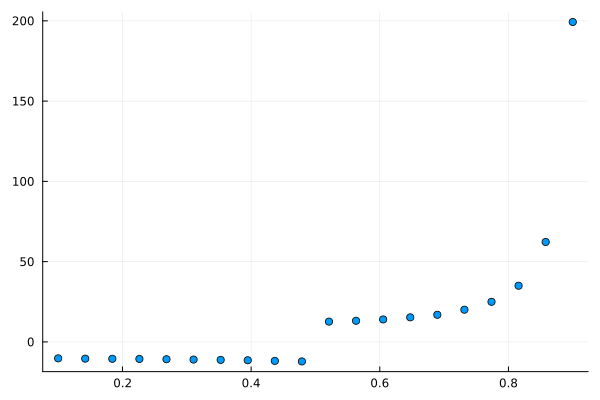

In [27]:
scatter(loss_gradient_data[:,1], loss_gradient_data[:,2],legend=false) # eccentricity vs gradient 